# Третья лабораторная. Методы машинного обучения

Лабораторная состоит из гайда по методам глубинного обучения (Deep Learning) и "продвинутым" методам машинного обучения (Machine Learning) на Python и пяти заданий:

* [Задание 1](#Задание-1.) - поиск гиперпараметров случайного леса

* [Задание 2](#Задание-2.) - поиск гиперпараметров нейросети для классификации

* [Задание 3](#Задание-3.) - поиск гиперпараметров для градиентного бустинга

* [Задание 4 (дополнительное)](#Задание-4-(дополнительное).) - выбор подходящих аугментаций. Это задание повышенной сложности, за него даётся 2.5 балла

* [Задание 5 (дополнительное)](#Задание-5-(дополнительное).) - выбор модели машинного обучения для решения задачи регрессии. За это задание можно получить 1 балл

Из пяти заданий требуется выполнить минимум первые 3 задания, за остальные задания можно заработать дополнительные баллы.

За попадание в топ 3 по качеству модели в заданиях 3, 4 и 5 можно получить по 1 дополнительному баллу за задание.

Задания 2, 3 и 4 последовательно связаны друг с другом - для одной задачи требуется добиться необходимого качества разными способами. Чтобы выполнить задание 3, требуется сначала выполнить задание 2, так как там обучается нейросеть для предобработки (имейте это в виду, если будете перезапускать ноутбук).

**Не забудьте** перед отправкой на проверку добавить в репозиторий сохранённые модели (файлы из папки `models`).

*В этом ноутбуке изначально опущены результаты исполнения кода. Рекомендуется запускать (Shift+Enter) ячейки по мере просмотра документа*

#### Используемые модули

Обновим пакетный менеджер pip, чтобы корректно уставить необходимые модули:

In [1]:
# При необходимости добавляйте опцию --user
!pip install --upgrade pip --user

Установим необходимые модули:

In [2]:
!pip install -r requirements.txt

Подключим модули, которые пригодятся в мини-лабораторной.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from google_drive_downloader import GoogleDriveDownloader as gdd
import os
from pathlib import Path

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.datasets import load_wine, fetch_openml
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import joblib

from catboost import CatBoostRegressor, CatBoostClassifier

import tensorflow as tf
from tensorflow.random import set_seed as set_random_seed
from keras import Model, Input
from keras.models import Sequential, load_model
from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical
from keras.layers import (Conv2D, MaxPooling2D, Flatten, Reshape, GlobalMaxPooling2D,
                          Activation, Dense, BatchNormalization)
from keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

from save_answer import add_to_answer

---

## Введение

Центральное понятие в машинном обучении - **модель**. Задачей машинного обучения является создание (обучение) модели, максимально <u>качественно</u> описывающей обучающие <u>данные</u>. Цель - получить модель, способную делать полезные предсказания по новым данным.

При этом критерии <u>качества</u> могут быть различными, и сильно влияют на результирующую модель. Определить *идеальный критерий*, подходящий для любого случая сложно (или невозможно). Это обусловлено как минимум двумя проблемами:
* Данные частично некорректны - содержат шум и выбросы.
    Шум возникает, например, из-за неточности измерений, а выбросы - чаще из-за ошибок; 
* Данные могут быть неполны - не полностью отражать действительность.

Для получения полезной с практической точки зрения модели, надо учитывать, что обучающие данные (training set) могут отличаться от данных, на которых требуется вычислять предсказания (evaluation / test set). 


Как правило задачи машинного обучения разделяют на две категории:

**1. [Обучение без учителя](https://scikit-learn.org/stable/unsupervised_learning.html)**

* [Кластеризация](https://scikit-learn.org/stable/modules/clustering.html);
* [Поиск ассоциативных правил](https://ru.wikipedia.org/wiki/Обучение_ассоциативным_правилам);
* [Понижение размерности](https://scikit-learn.org/stable/modules/unsupervised_reduction.html);
* [Поиск выбросов](https://scikit-learn.org/stable/modules/outlier_detection.html).

**2. [Обучение с учителем](https://scikit-learn.org/stable/supervised_learning.html)**

* [Классификация](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html);
* Регрессия;
* Ранжирование;
* [Анализ выживаемости / рисков](https://nbviewer.jupyter.org/github/sebp/scikit-survival/blob/master/examples/00-introduction.ipynb).

Но также есть множество задач, не вписывающихся в эти категории, например:

* Multiple-instance Learning - целевые значения сопоставлены группам (bag) наблюдений;
* One-shot Learning - классификация с одним обучающим примером для каждого класса;
* Similarity Learning - поиск меры схожести объектов;
* Reinforcement Learning - обучение модели, совершающей действия в ходе взаимодействия со средой;
* Collaborative Filtering - построение рекомендаций;
* Natural Language Processing: машинный перевод, QA - получение текстового ответа на текстовый вопрос;
* Перенос стиля, генерирование изображений.

Поэтому перед созданием модели лучше не сразу пытаться свести задачу к базовым задачам машинного обучения (классификации, регрессии), а поискать модели, использующие специфику области. Например, для машинного перевода специфичен порядок слов в предложении, и правильных переводов может быть несколько - решение задачи без использования этих особенностей приводит к крайне плохим результатам. 

### Overfitting / Underfitting

Чтобы полученная модель была практически применима, надо соблюсти баланс между переобучением (overfitting) и недообучением (underfitting):
* переобучение возникает, когда модель имеет минимальную ошибку на обучающем множестве, и значительно большую на тестовом;
* недообучение возникает при использовании слишком простых моделей, которые не могут обеспечить достаточно маленькую среднюю ошибку даже на тренировочных данных.

В качестве примера рассмотрим задачу одномерной регрессии с синтетическими данными:

Обучающее множество: $\{(x_i, y_i)\}_{i=1}^{n}$,
где $x_i$ - наблюдения $x \sim U([0; 1]); \varepsilon \sim N(0, 0.1)$, 
$y = f(x) + \varepsilon$,

$f(x) = \cos(5 x + \frac{\pi}{2})$

Для простоты будем использовать полиномиальную модель:

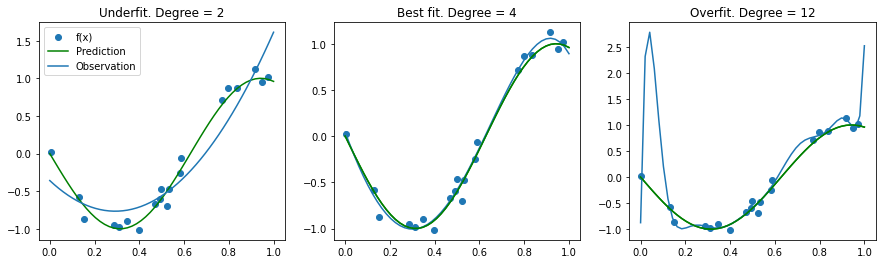

In [4]:
np.random.seed(239)

def f(x):
    return np.cos(x * 5 + np.pi/2)

X = np.sort(np.random.rand(20))
y = f(X) + np.random.normal(0, 0.1, len(X))

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
X_lin = np.linspace(0, 1, 50)  # массив 50 чисел от 0 до 1
titles = ["Underfit. Degree = 2", "Best fit. Degree = 4", "Overfit. Degree = 12"]
for i, title in enumerate(titles):
    ax[i].set_title(title)
    ax[i].scatter(X, y)  # наблюдения
    ax[i].plot(X_lin, f(X_lin), color='g')  # целевая функция
# модель - полином, подбор коэффициентов - МНК
predictor_underfit = np.poly1d(np.polyfit(X, y, deg=2))
ax[0].plot(X_lin, predictor_underfit(X_lin))

predictor_best = np.poly1d(np.polyfit(X, y, deg=4))
ax[1].plot(X_lin, predictor_best(X_lin))
ax[1].plot(X_lin, f(X_lin), color='g')

predictor_overfit = np.poly1d(np.polyfit(X, y, deg=12))
ax[2].plot(X_lin, predictor_overfit(X_lin))
ax[2].plot(X_lin, f(X_lin), color='g')

ax[0].legend(["f(x)", "Prediction", "Observation"])

plt.show()

Заметим, что третий вариант аппроксимации функции (с переобучением) очевидно не может быть использован на практике. Как минимум, из-за слишком больших значений в промежутке от 0 до 0.1.

Однако о первом варианте (с недообучением) такого сказать нельзя. Хотя полученная функция не совпадает с $f(x)$, она достаточно неплохо оценивает обучающее множество. На практике при малом числе наблюдений и большой размерности пространства сложные модели скорей всего будут склонны к переобучению, тогда как простые, вроде линейной регрессии, будут давать хоть насколько-то верную аппрокимацию.

Посмотрим на ошибки в данном примере на обучающем множестве:

In [5]:
def print_err(title, model, x, y_true):
    mse = mean_squared_error(y_true, model(x))
    mae = mean_absolute_error(y_true, model(x))
    r2  = r2_score(y_true, model(x))
    print(title)
    print(f"MSE: {mse:.3f}, MAE: {mae:.3f}, R^2: {r2:.3f}\n")

for i, model in enumerate([predictor_underfit, predictor_best, predictor_overfit]):
    print_err(titles[i], model, X, y)

Underfit. Degree = 2
MSE: 0.060, MAE: 0.206, R^2: 0.894

Best fit. Degree = 4
MSE: 0.007, MAE: 0.068, R^2: 0.987

Overfit. Degree = 12
MSE: 0.005, MAE: 0.045, R^2: 0.992



Здесь $R^2$ - это коэффициент детерминации. Его множество значений от $-\infty$ до $1$.

Эти значения ошибок показывают насколько хорошо модель смогла запомнить обучающие данные.

Попробуем применить модель к новым данным:

In [6]:
X_test = np.sort(np.random.rand(200))
y_test = f(X_test) + np.random.normal(0, 0.1, len(X_test))

for i, model in enumerate([predictor_underfit, predictor_best, predictor_overfit]):
    print_err(titles[i], model, X_test, y_test)

Underfit. Degree = 2
MSE: 0.060, MAE: 0.205, R^2: 0.887

Best fit. Degree = 4
MSE: 0.010, MAE: 0.079, R^2: 0.982

Overfit. Degree = 12
MSE: 0.527, MAE: 0.335, R^2: 0.007



Видно, что качество предсказания первых двух моделей почти не упало, когда как третья (переобученная) даёт ошибку на два порядка больше. Таким образом можно выбрать наиболее корректную модель.

Формально, разность между риском (математическим ожиданием ошибки) и эмпирическим риском (средним значением ошибки на обучающем множестве), называется **переобученностью**.

В примере мы смогли **сгенерировать** новый набор данных, на котором проверяли насколько хорошо подходит модель, **приближая** значение переобученности (вместо математического ожидания ошибки мы вычисляли среднюю, но **не** на обучающем множестве). На практике сгенерировать новый набор данных может быть трудоёмко, или вообще невозможно, поэтому нужно уметь оценивать модель, имея только один (тренировочный) набор данных. Но как?

### Кросс-валидация (Cross-Validation)

Для того, чтобы понять насколько хорошо подходит модель, воспользуемся [перекрёстной проверкой](https://ru.wikipedia.org/wiki/Перекрёстная_проверка) на имеющихся обучающих данных: будем обучать модель $k$ раз, каждый раз выделяя $k-1$ долей обучающего множества для обучения модели (с нуля), используя оставшуюся долю для оценки качества. Это позволит оценить не только качество модели, но и чувствительность к обучающим данным, причём численно.

Часто модели имеют гиперпараметры (параметры, значения которых фиксируются до начала обучения, например количество слоёв в нейронной сети). В примере выше гиперпараметр - это степень полинома. Подберём оптимальные гиперпараметры с помощью C-V. Для этого можно воспользоваться одной из следующих готовых реализаций:
* [Grid-search C-V](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) - перебор значений гиперпараметров на некоторой сетке;
* [Randomized search C-V](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) - перебор случайных значений гиперпараметров;
* [Bayesian C-V](https://scikit-optimize.github.io/notebooks/bayesian-optimization.html) - перебор значений гиперпараметров, используя модифицируемое по ходу представление о форме поверхности ошибки. Реализован в библиотеке [hyperopt](https://hyperopt.github.io/hyperopt/).

Наиболее популярный на данный момент метод - Bayesian C-V, но для простоты рассмотрим классический Grid-search C-V:

In [7]:
# полиномиальный регрессор - то же самое, что линейная регрессия с признаками (x^0, x^1, x^2, ..., x^k)
polynomial_regressor = make_pipeline(PolynomialFeatures(), LinearRegression())
# сетка параметров степени полинома - целые значения от 0 до 14:
parameters = {'polynomialfeatures__degree': range(15)}

# scoring - минимизируемая метрика: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
search = GridSearchCV(polynomial_regressor, parameters, cv=5, scoring='neg_mean_squared_error')
search.fit(X[:, np.newaxis], y)
print(f"Best loss (-MSE): {search.best_score_}")
print(f"Best parameters: {search.best_params_}")

Best loss (-MSE): -0.13969269572542442
Best parameters: {'polynomialfeatures__degree': 5}


Проблему переобучения также можно решать с помощью регуляризации (например, в случае линейных моделей – Lasso, Ridge). При этом возникают дополнительные параметры, которые имеет смысл также перебирать с помощью кросс-валидации.

## Продвинутые методы машинного обучения

### Ансамблевые методы

Основная идея ансамблевых методов заключается в построении набора различных примитивных базовых моделей и использовании их комбинации для предсказаний.

Это позволяет бороться с двумя проблемами:
1. Переобучение - за счёт различия моделей (структуры или данных, на которых модели обучаются);
2. Низкое качество предсказаний - для большинства моделей за счёт т.н. "мудрости толпы".

В качестве базовых моделей могут использоваться любые методы, от линейной регрессии до нейронных сетей, однако стоит учитывать, что:
* время построения ансамбля сложных моделей будет очень велико. Простые же модели можно строить параллельно;
* на [bias-variance trade-off](https://habr.com/ru/company/ods/blog/323890/#razlozhenie-oshibki-na-smeschenie-i-razbros-bias-variance-decomposition) влияет сложность каждой базовой модели и их количество. Наиболее сложные базовые модели не всегда позволяют получать лучшее качество.

#### 1. Случайный лес

Случайный лес - ансамбль решающих деревьев (построенных по CART). Финальный прогноз производится усреднением результатов работы каждого дерева.

Для получения различных деревьев используются два принципа:
* Bagging (Bootstrap aggregation) - выборка для каждого дерева формируется случайным образом (с возвратом) из тренировочной. Методы, использующие bagging всегда могут оценивать ошибку на "out of bag" элементах начальной выборки - тех, что не вошли ни в одну из подвыборок;
* Random feature subspace - в качестве признаков каждое дерево рассматривает случайное подмножество исходных признаков.

Одним из основных преимуществ случайных лесов для классификации является возможность предсказать не только класс, но и "уверенность" - аппроксимацию вероятности данного класса при условии входных данных. Также они могут применяться для подбора наиболее релевантных признаков - т.н. feature importances.

Рассмотрим простую задачу регрессии House Prices:

In [8]:
# Загружаем датасет
# Функция загрузки fetch_openml возвращает пару pandas-датафреймов (таблиц, мы с ними знакомились в первой мини-лабораторной)
housing_x, housing_y = fetch_openml(name="house_prices", return_X_y=True, as_frame=True)

# Посмотрим на фичи (признаки) из датасета
housing_x.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1.0,60.0,RL,65.0,8450.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2008.0,WD,Normal
1,2.0,20.0,RL,80.0,9600.0,Pave,None,Reg,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,5.0,2007.0,WD,Normal
2,3.0,60.0,RL,68.0,11250.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,9.0,2008.0,WD,Normal
3,4.0,70.0,RL,60.0,9550.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,2.0,2006.0,WD,Abnorml
4,5.0,60.0,RL,84.0,14260.0,Pave,None,IR1,Lvl,AllPub,...,0.0,0.0,None,None,None,0.0,12.0,2008.0,WD,Normal


Видим, что в таблице есть не только числовые, но и категориальные признаки (например, `MSZoning`, `LotShape` и т.д.).

Обработка категориальных признаков - отдельная тема, на которую обычно выделяется часть лекции. Мы же в рамках примера оставим только числовые признаки.

_На самом деле код ниже уберёт столбцы, тип которых нечисловой, но это ещё не означает, что мы убрали категориальные признаки - некоторые категориальные признаки могут в данных быть выражены в числах - это мы в данном случае проигнорируем, но стоит об этом помнить._

In [9]:
# Уберём все колонки, тип которых нечисловой
housing_x = housing_x.select_dtypes(['number'])

# Уберём все строки, где есть NaN - для этого надо убрать строки и в housing_x, и в housing_y.
# Чтобы корректно почистить датафреймы, сначала соединим их в 1 датафрейм, почистим его, а потом "расщепим" обратно
housing_merged = housing_x.join(housing_y)  # Соединяем датафреймы
housing_merged = housing_merged.dropna(how='any')  # Чистим
# Расщепляем датафрейм обратно на признаки объектов и их метки. В роли меток выступает SalePrice - цена дома
housing_y, housing_x = housing_merged["SalePrice"], housing_merged.drop(columns="SalePrice")

---

#### Задание 1.

В коде ниже приведён пример запуска `RandomForestRegressor`.

Требуется подобрать параметры (кроме `random_state` и `oob_score`) у `RandomForestRegressor`, чтобы [коэффициент детерминации $R^2$](http://www.machinelearning.ru/wiki/index.php?title=Коэффициент_детерминации) (оценка качетва) увеличился на **тестовых данных** до **0.75**.

_В этом задании и последующих рекомендуется использовать автоматический подбор гиперпараметров вместо того, чтобы подбирать гиперпараметры вручную после каждого обучения модели, которая не смогла достичь требуемого качества._

In [24]:
def model_score(X, y, estimator=None, cv=3, scoring=None):
    scores = cross_val_score(estimator, X, y, cv=cv, scoring=scoring)
    return np.mean(scores)

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(housing_x, housing_y, test_size=0.25, random_state=12345)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rfc = RandomForestClassifier()
rs = RandomizedSearchCV(rfc,
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=0)
rs.fit(X_train, y_train)
print(rs.best_params_)



# Ваши значения параметров - это параметры для RandomForestRegressor,
# указанные в словаре housing_params
housing_params = {
    "n_estimators": 100,
    "max_depth": 8,
    "min_samples_split": 18,
    "min_samples_leaf": 23,
    "criterion": 'squared_error',
}

housing_rf = RandomForestRegressor(
    # `random_state` оставьте зафиксированным, чтобы можно было повторить ваш результат
    random_state=12345,
    oob_score=True,
    # две звёздочки означают раскрытие словаря и передачу именованных параметров из словаря
    # прямо в конструктор RandomForestRegressor
    **housing_params,
)


housing_rf.fit(X_train, y_train)

cv_score = model_score(X_train, y_train, estimator=housing_rf, cv=10, scoring='r2')
train_score = housing_rf.score(X_train, y_train)
test_score = housing_rf.score(X_test, y_test)
oob_score = housing_rf.oob_score_
print("Score (R^2) on train:")
print(f"Out of bag training score estimation: {oob_score}")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print("Требуемое качество на тестовых данных " + ("получено" if test_score > 0.75 else "НЕ получено"))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\VasilisaK\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


{'n_estimators': 100, 'min_samples_split': 18, 'min_samples_leaf': 23, 'max_features': 'sqrt', 'max_depth': 8, 'bootstrap': True}
Score (R^2) on train:
Out of bag training score estimation: 0.7916839377094576
Cross-validation on train score: 0.7878392990108549
Train score: 0.8295716148657736
Test score: 0.7721317117761567
Требуемое качество на тестовых данных получено


Не забудьте сохранить ответы

In [25]:
rf_housing_model_path = os.path.join("models", "task_1.joblib")
# Создаём папку, куда сохраним результаты, если папки ещё нет
Path("models").mkdir(parents=True, exist_ok=True)

joblib.dump(housing_rf, rf_housing_model_path)  # Сохраняем итоговую модель

add_to_answer(
    "task_1",
    {
        # Перед сохранением убедитесь, что подобранные параметры
        # действительно содержатся в словаре housing_params!
        "params": housing_params,
        "model_path": rf_housing_model_path,
    },
)

---

Ещё одной интересной особенностью ансамблей деревьев является возможность подсчитать "*важность*" признаков. Сделаем это для рассматриваемого датасета:

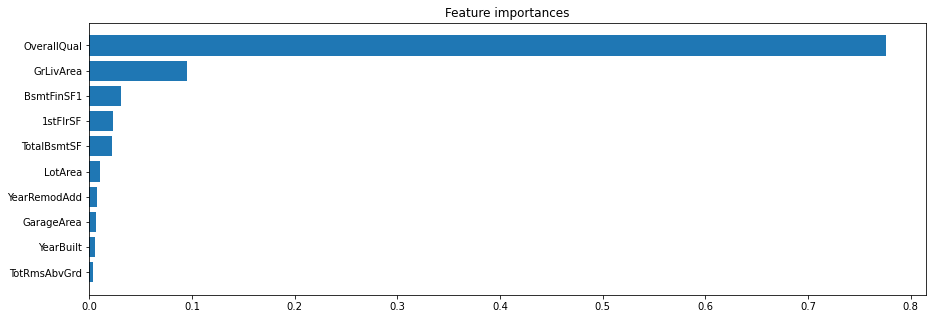

In [26]:
importances = housing_rf.feature_importances_

ind = np.argsort(importances)[-10:]  # Найдём индексы топ-10 самых важных признаков

plt.figure(figsize=(15, 5))
plt.barh(housing_x.columns[ind], importances[ind])
plt.title("Feature importances")
plt.show()

Помимо того, что *важность* признаков сама по себе может быть полезной информацией для конечного пользователя, на основе неё можно производить автоматический отбор признаков.

Однако следует быть осторожным с использованием такого механизма. Жадная природа алгоритма построения дерева решений может привести к неадекатным значениям такой *важности* признаков. Более надёжных методом (но тоже не идеальным!), подходящим для любых моделей, а не только для лесов, является, например, *permutation importance*.

На практике помимо базового Random Forest также применяют модификации:
* Extra Random Trees - деревья строятся не по алгоритму CART, вместо этого каждое правило деления (split point) выбирается случайным образом, после чего выбирается наиболее релевантный признак. Получается быстрое время построения, но не минимальная ошибка;
* Rotation Random Forest - перед построением каждого дерева к набору предназначенных ему признаков применяется PCA (что означает поворот осей). Такой метод полезно использовать при больших размерностях пространства признаков.

#### 2. [Градиентный бустинг](https://en.wikipedia.org/wiki/Gradient_boosting)

Градиентный бустинг тоже является ансамблевым методом и имеет следующие особенности:
* деревья строятся последовательно - каждая следующая модель старается улучшить ошибку предыдущей, аппроксимируя антиградиент <u>функции потерь</u>;
* результат работы считается как взвешенная сумма результатов базовых моделей, веса которой определяются линейным поиском на этапе построения ансамбля;
* в случае классификации, в сравнении со случайными лесами, градиентный бустинг не позволяет хранить в листьях деревьев классы напрямую. Вместо этого алгоритм находит вероятности классов, как в логистической регрессии. Попробуйте ответить почему это так?

Модели, опирающиеся на градиентный бустинг часто дают наиболее высокое качество, в сравнении со случайными лесами, линейной регрессией, SVM и т.д.
Однако используя градиентный бустинг гораздо легче прийти к переобучению.

Одним из способов борьбы с переобучением является введение скорости обучения `learning rate` - константного множителя для каждой новой базовой модели.

Посмотрим как градиентный бустинг справляется с задачей регрессии на том же датасете:

In [27]:
housing_gbm = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.1,
    n_estimators=100,
    subsample=.5,  # стохастический бустинг - деревья строятся по случайным подвыборкам
    criterion='friedman_mse',
    max_depth=3,
    random_state=12345,
)
housing_gbm.fit(X_train, y_train)

cv_score = model_score(X_train, y_train, estimator=housing_gbm, cv=10, scoring='r2')
train_score = housing_gbm.score(X_train, y_train)
test_score = housing_gbm.score(X_test, y_test)

print("Score (R^2) on train:")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Score (R^2) on train:
Cross-validation on train score: 0.8856070965266938
Train score: 0.9719089934613121
Test score: 0.7141863612063776


На практике градиентный бустинг из библиотеки sklearn обычно не применяют. Вместо него используют одну из трёх(+) библиотек, в каждой из которых реализованы свои усовершенствования оригинального алгоритма:
* [XGBoost](https://xgboost.readthedocs.io/en/latest/) - первая библиотека, реализующая градиентный бустинг на GPU (2014 год);
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/) - библиотека от Microsoft Research (2017 год), в которой реализована обработка категориальных признаков и усовершенствования производительности;
* **[CatBoost](https://catboost.ai/)** - библиотека от Yandex (2017 год), в которой реализована продвинутая обработка категориальных признаков и методы борьбы с переобучением. Чаще всего в задачах с категориальными признаками CatBoost работает лучше других алгоритмов даже без подстройки параметров, однако чтобы ощутить преимущество следует не применять препроцессинг для категориальных признаков. По словам команды разработчиков, использованный метод построения симметричных деревьев (Oblivious Trees) даёт прирост в качестве во всех случаях. Хотя определяющий фактор для применения таких деревьев – эффективность реализации на GPU.

Проверим смелое утверждение разработчиков `CatBoost`, не меняя ни одного параметра:

In [28]:
housing_catboost = CatBoostRegressor(
    verbose=False,
    allow_writing_files=False,  # не пишем логи, о них ниже
    task_type='CPU',  # или 'GPU'
)
housing_catboost.fit(X_train, y_train, eval_set=(X_test, y_test))

cv_score = model_score(X_train, y_train, estimator=housing_catboost, cv=10, scoring='r2')
train_score = r2_score(y_train, housing_catboost.predict(X_train))
test_score = r2_score(y_test, housing_catboost.predict(X_test))

print("Score (R^2) on train:")
print(f"Cross-validation on train score: {cv_score}")
print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

Score (R^2) on train:
Cross-validation on train score: 0.897932185925525
Train score: 0.9230097644728974
Test score: 0.8046633561162339


#### Визуализация

При обучении моделей градиентного бустинга или сетей очень полезно строить графики функции потерь для тренировочной и тестовой выборок.

*CatBoost* сохраняет логи обучения по умолчанию (если `allow_writing_files == True`) в формат, совместимый с *TensorBoard* и *CatBoost Viewer*. Использовать *TensorBoard* для просмотра логов крайне удобно: достаточно установить *TensorBoard* (`pip install tensorboard`) и запустить его командой `tensorboard --logdir=catboost_info`. Сохранять результаты запусков алгоритма с различными параметрами можно с помощью записи логов в подкаталоги с уникальными именами. С установкой *CatBoostViewer* могут возникнуть небольшие сложности, поскольку он реализован с использованием *NodeJS*.

### Нейронные сети

Если вы планируете использовать нейронные сети, имеет смысл ознакомиться с [этим](https://github.com/abidlabs/AtomsOfDeepLearning/blob/master/Atomic%20Experiments%20in%20Deep%20Learning.ipynb) ноутбуком (но для выполнения лабораторной это не обязательно). 

С нейронными сетями чаще всего гораздо сложнее работать, чем с градиентным бустингом: приходится подбирать архитектуру, настраивать огромное число гиперпараметров; нет возможности узнать, по какому принципу сеть находит ответ. Однако есть ситуации, в которых нейронные сети просто не имеют адекватно работающих альтернатив:
* обработка изображений, видео - Convolutional NN;
* построение эмбеддинга с учителем и без учителя - AutoEncoder, Siamese NN;
* работа с последовательностями, в том числе генерирование - Recurrent NN и **Transformer**;
* создание генеративных моделей без учителя - Generative Adversarial Networks, Noise Conditional Score Network, и т.д.

Большая часть преимуществ достигается из-за возможности точно управлять целью обучения с помощью функции потерь, а также возможности использовать части обученной сети для решения новой задачи. Например, научив сеть предсказывать корректность словосочетания, можно применять найденный сетью способ кодирования слов для нахождения семантической близости.

#### Кратко о фреймворках

Есть несколько актуальных на данный момент фреймворков для работы с нейронными сетями:
* TensorFlow - построение статических графов вычислений, автоматический вывод градиентов, блоки для построения сетей. Имеет высокий "порог вхождения". С версии `2.0` поддерживает т.н. eager-вычисления, т.е. динамические графы. Обратная совместимость с версиями `1.*` частично отсутствует и может потреобвать переписывания части кода;
* PyTorch - построение динамических графов вычислений, лёгкий перенос вычислений на GPU (требует изменения кода);
* Keras - построение нейронных сетей из блоков. Вычисления производятся с помощью одного из низкоуровневых фреймворков (backend): TensorFlow, CNTK, Theano и др.

Если не требуется реализовывать принципиально новый алгоритм машинного обучения, внедрять наиболее современные механизмы и т.д., проще всего использовать Keras.

Для некоторых архитектур нейронных сетей пишут профильные оптимизированные решения (например, для [YOLO](https://pjreddie.com/darknet/yolo/) - алгоритма быстрого поиска объектов на изображениях реализована низкоуровневая поддержка в библиотеке [Darknet](https://github.com/pjreddie/darknet)). Фреймворки вроде TensorFlow, хоть и обеспечивающие работу с несколькими GPU в кластерах, часто проигрывают по производительности узкопрофильным решениям. На практике, если применяют TensorFlow, как правило используют [оптимизаторы](https://developer.nvidia.com/tensorrt) для ускорения инференса, а для этапа тренировки тратят приличное число ресурсов.


#### Пример

Воспользуемся фреймворком `Keras`, который работает на `Tensorflow`.

Построим сеть для решения задачи регрессии, рассмотренной выше.

В Keras удобно строить сеть как последовательность слоёв, для этого используется *Sequential*-модель:

In [29]:
def make_dense_model():
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(60))
    model.add(Activation('relu'))
    model.add(Dense(1))
    # чтобы модель можно было тренировать и использовать, необходимо её скомпилировать
    model.compile(optimizer='adam', loss='mae')
    
    return model


dense_model = make_dense_model()

Попробуем натренировать модель:

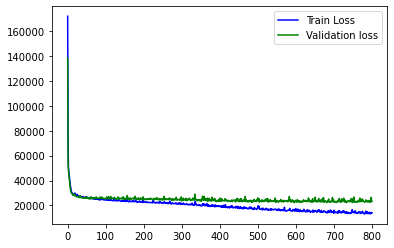

In [30]:
np.random.seed(1)
set_random_seed(1)

n_epochs = 800

history = dense_model.fit(
    X_train, y_train,
    epochs=n_epochs,
    # число примеров, на которых считается градиент:
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=False,  # Отключаем вывод, чтобы не перегружать ноутбук лишним выводом
)

plt.plot(range(n_epochs), (history.history['loss']), c='b')
plt.plot(range(n_epochs), (history.history['val_loss']), c='g')
plt.legend(['Train Loss', 'Validation loss'])
plt.show()

Рассмотрим параметры обучения:
* `epochs` - число эпох. Эпоха заканчивается, когда сеть увидела все примеры тренировочного множества;
* `batch_size` - размер мини-батча. В [SGD](http://www.machinelearning.ru/wiki/index.php?title=Стохастический_градиентный_спуск) элементы обучающей выборки разбиваются на группы (мини-батчи) и функция потерь, вместе с её производной, рассчитывается на мини-батчах. Веса обновляются после просмотра каждого мини-батча. Вычислительно выгодней, чтобы мини-батч был достаточно большого размера, поскольку в таком случае данные будут обрабатываться параллельно;
* `validation_data` - данные для построения кривой ошибки на валидационных данных "Validation loss".

По графику функции потерь (loss) можно судить о том, имеет ли смысл обучать сеть большее число итераций.

Посмотрим на качество полученной сети:

In [31]:
train_score = r2_score(y_train, dense_model.predict(X_train))
test_score  = r2_score(y_test, dense_model.predict(X_test))

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

9/9 [==============================] - 0s 1ms/step
Train score: 0.9332390777172423
Test score: 0.6655895874414526


Получить те же результаты можно за меньшее число эпох обучения с помощью стандартизации входных данных.
Так происходит из-за того, что в противном случае сети приходится самой сначала "искать положение данных".

Сделаем предобработку с помощью `StandardScaler` для векторов признаков и `MinMaxScaler` для целевого.
А после каждого полносвязного (`Dense`) слоя поставим `BatchNormalization` - этот механизм стандартизации внутри сети рекомендуется применять почти во всех случаях. Грубо говоря, без него каждый слой сам должен "искать положение" своих входных данных, хотя эту операцию можно сделать явно.

In [32]:
X_train, X_test = X_train.to_numpy(), X_test.to_numpy()
y_train, y_test = y_train.to_numpy(), y_test.to_numpy()

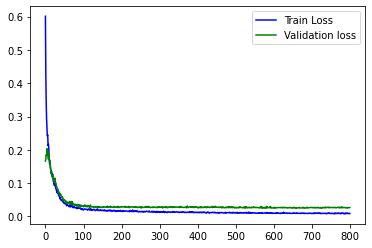

In [33]:
np.random.seed(1)
set_random_seed(1)

scaler = StandardScaler()
target_scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(y_train.shape[0], 1))
X_test_scaled = scaler.transform(X_test)
y_test_scaled = target_scaler.transform(y_test.reshape(y_test.shape[0], 1))


def make_dense_scaled_model():
    model = Sequential()
    model.add(Dense(100, input_dim=X_train.shape[1]))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(200))
    # Добавились слои BatchNormalization
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dense(60))
    model.add(Activation('relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae')
    return model
    
    
dense_scaled_model = make_dense_scaled_model()

history = dense_scaled_model.fit(X_train_scaled, y_train_scaled,
                                 epochs=n_epochs,
                                 batch_size=32,
                                 validation_data=(X_test_scaled, y_test_scaled),
                                 verbose=False)

plt.plot(range(len(history.history['loss'])), history.history['loss'], c='b')
plt.plot(range(len(history.history['val_loss'])), history.history['val_loss'], c='g')
plt.legend(['Train Loss', 'Validation loss'])
plt.show()

In [34]:
def scaled_predict(model, X, target_scaler=target_scaler):
    return target_scaler.inverse_transform(model.predict(X))


train_score = r2_score(y_train, scaled_predict(dense_scaled_model, X_train_scaled))
test_score  = r2_score(y_test, scaled_predict(dense_scaled_model, X_test_scaled))

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")

9/9 [==============================] - 0s 1ms/step
Train score: 0.987747177080703
Test score: 0.7510153917936089


Почистим ресурсы - освободим память от обученных моделей, чтобы приступить к следующей части лабораторной работы

In [35]:
del dense_model
del dense_scaled_model

---

### Нейронные сети для обработки изображений

Загрузим датасет fashion mnist, содержащий изображения одежды (grayscale 28x28) 10 различных классов:

In [36]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Переводим цвета из диапазона [0, 255] к диапазону [0, 1]
train_images = train_images / 255.0
test_images  = test_images / 255.0
# Переводим числовые метки в категориальные - вместо номера класса от 0 до 9 будем использовать векторы
# из 10 элементов, где все нули, кроме единицы на i-ой позиции для i-го класса.
# Такой подход позволяет избежать негативных эффектов при обучении, т.к. между классами нет строгого линейного порядка,
# как в случае с числами от 0 до 9.
train_vectors = to_categorical(train_labels)
test_vectors = to_categorical(test_labels)

4422102/4422102 [==============================] - 4s 1us/step


Будем пользоваться библиотекой `keras-tuner` для автоматического подбора гиперпараметров. Для того, чтобы с помощью этой библиотеки подобрать гиперпараметры, надо определить функцию, принимающую на вход специальный объект `hp` и возвращающую построенную модель.

У объекта `hp` можно вызывать методы `Choice`, `Int`, `Boolean` и другие для указания, из каких значений перебирать гиперпараметры в данном месте.

Ниже приведён пример кода, где определяется функция `build_model`, которая будет передана "тюнеру" для поиска лучших гиперпараметров.

In [37]:
np.random.seed(1)
set_random_seed(1)

def build_model(hp):
    image_model = Sequential()
    image_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    image_model.add(BatchNormalization())
    image_model.add(MaxPooling2D())
    
    # В следующем слое сообщаем keras tuner гиперпараметры, из которых надо искать лучшие
    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров
                                'second_conv2d_out_channels',  # название нашего гиперпараметра, для которого ищем значение
                                min_value=4,
                                max_value=5,
                                step=1,
                            ),
                           kernel_size=(3, 3), strides=(1, 1),
                           activation=hp.Choice(  # Перебираем значения в качестве гиперпараметров
                               'second_conv2d_activation',  # название нашего гиперпараметра, для которого ищем значение
                               ['relu', 'tanh'],  # список, из которого можно выбирать значения гиперпараметра
                           )))
    
    # Следующий гиперпараметр - "наличие слоя батч-нормализации"
    if hp.Boolean("need_batch_norm_after_second_conv2d"):
        # Сюда зайдём в случае, когда keras-tuner подставит True в качестве гиперпараметра need_batch_norm_after_second_conv2d
        # И тогда в модель будет добавлен слой батч-нормализации
        image_model.add(BatchNormalization())
    
    image_model.add(MaxPooling2D())
    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    image_model.add(BatchNormalization())
    image_model.add(Flatten())

    image_model.add(Dense(4, activation='relu'))
    image_model.add(Dense(10, activation='softmax'))
    image_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    # Функция должна возвращать построенную и скомпилированную модель
    return image_model

Далее создадим тюнер, который будет искать лучшие гиперпараметры из заданных с помощью случайного поиска (random search).

Случайный поиск используется, когда возможных конфигураций модели слишком много, так как процесс обучения одной модели может быть затратным. При случайном поиске гиперпараметры будут выбираться из возможных случайным образом. Нам нужно лишь указать максимальное количество различных моделей, которые следует обучать.

Лучшими гиперпараметрами тюнер считает модель, которая после обучения показала лучшее качество по метрике, переданной аргументом `objective`.

In [38]:
# Создаём тюнер
tuner = kt.RandomSearch(
    build_model,  # Передаём функцию, определённую выше
    objective='val_loss',  # Передаём критерий качества лучшей модели
    max_trials=3,  # Максимальное кол-во возможных конфигураций, которые тюнер "проверит"
    seed=1234,
)

# Запускаем процесс поиска
# В качестве аргументов передаём всё то, что передали бы в метод fit, если бы подбора гиперпараметров не было
tuner.search(train_images, train_vectors, epochs=5, batch_size=128, validation_data=(test_images, test_vectors))

Trial 3 Complete [00h 00m 39s]
val_loss: 0.5765729546546936

Best val_loss So Far: 0.5765729546546936
Total elapsed time: 00h 01m 56s
INFO:tensorflow:Oracle triggered exit


Посмотрим итоги поиска

In [39]:
tuner.results_summary()

Results summary
Results in .\untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: True
Score: 0.5765729546546936
Trial summary
Hyperparameters:
second_conv2d_out_channels: 4
second_conv2d_activation: relu
need_batch_norm_after_second_conv2d: True
Score: 0.617464542388916
Trial summary
Hyperparameters:
second_conv2d_out_channels: 5
second_conv2d_activation: tanh
need_batch_norm_after_second_conv2d: False
Score: 0.6291934847831726


Создадим модель, которую тюнер признал лучшей

In [40]:
best_model = tuner.get_best_models()[0]  # Создадим модель
best_model.build(input_shape=(None, 28, 28))  # Построим модель с лучшими гиперпараметрами
best_model.summary()  # Посмотрим на архитектуру построенной модели, она соответствует выбранным гиперпараметрам

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 4)         40        
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 4)        16        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 5)         185       
                                                                 
 batch_normalization_1 (Batc  (None, 11, 11, 5)        2

Замерим `accuracy` для найденной модели на тестовых данных

In [41]:
# Так как мы кодировали метки векторами, можем раскодировать их обратно,
# воспользовавшись функцией argmax - находит индекс максимального элемента вектора
print(f"Качество найденной модели: {accuracy_score(test_labels, np.argmax(best_model.predict(test_images), axis=-1))}")

313/313 [==============================] - 1s 3ms/step
Качество найденной модели: 0.7936


#### Задание 2.

Измените параметры свёрточной сети / параметры обучения (метода `fit`), чтобы повысить качество (accuracy) на **тестовых данных** до **0.88**.

При желании можно использовать автоматический подбор гиперпараметров с помощью keras-tuner, но можно обойтись и без него.

Если Вы перезапустили ноутбук, надо заново загрузить датасет, выполнив начальную ячейку с кодом в разделе [Нейронные сети для обработки изображений](#Нейронные-сети-для-обработки-изображений).

In [132]:

np.random.seed(1)
set_random_seed(1)

classification_model = Sequential()
classification_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
# далее input_shape указывать не обязательно
# следует изменить параметры следующих слоёв:
classification_model.add(Conv2D(18, kernel_size=(3, 3), strides=(1, 1),
                       input_shape=(28, 28, 1), activation='relu'))
classification_model.add(BatchNormalization())
classification_model.add(MaxPooling2D())
classification_model.add(Conv2D(17, kernel_size=(3, 3), strides=(1, 1),
                       input_shape=(14, 14, 4), activation='relu'))
classification_model.add(BatchNormalization())
classification_model.add(MaxPooling2D())
classification_model.add(Conv2D(18, kernel_size=(3, 3), strides=(1, 1),
                       input_shape=(7, 7, 4), activation='relu'))
classification_model.add(BatchNormalization())

# Слой ниже (и последующие слои) менять не надо
classification_model.add(Flatten(name='flatten'))
classification_model.add(Dense(4, activation='relu'))
classification_model.add(Dense(10, activation='softmax'))


'''
np.random.seed(1)
set_random_seed(1)

def build_model(hp):
    image_model = Sequential()
    image_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
#    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
#    image_model.add(BatchNormalization())
#    image_model.add(MaxPooling2D())
    
    # В следующем слое сообщаем keras tuner гиперпараметры, из которых надо искать лучшие
    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров
                                'second_conv2d_out_channels',  # название нашего гиперпараметра, для которого ищем значение
                                min_value=4,
                                max_value=5,
                                step=1,
                            ),
                           kernel_size=(3, 3), strides=(1, 1), input_shape=(28, 28, 1),
                           activation=hp.Choice(  # Перебираем значения в качестве гиперпараметров
                               'second_conv2d_activation',  # название нашего гиперпараметра, для которого ищем значение
                               ['relu', 'tanh'],  # список, из которого можно выбирать значения гиперпараметра
                           )))
    
    # Следующий гиперпараметр - "наличие слоя батч-нормализации"
#    if hp.Boolean("need_batch_norm_after_second_conv2d"):
        # Сюда зайдём в случае, когда keras-tuner подставит True в качестве гиперпараметра need_batch_norm_after_second_conv2d
        # И тогда в модель будет добавлен слой батч-нормализации
#        image_model.add(BatchNormalization())
    image_model.add(BatchNormalization())
    image_model.add(MaxPooling2D())
    
        # В следующем слое сообщаем keras tuner гиперпараметры, из которых надо искать лучшие
    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров
                                'second_conv2d_out_channels',  # название нашего гиперпараметра, для которого ищем значение
                                min_value=4,
                                max_value=5,
                                step=1,
                            ),
                           kernel_size=(3, 3), strides=(1, 1), input_shape=(14, 14, 4),
                           activation=hp.Choice(  # Перебираем значения в качестве гиперпараметров
                               'second_conv2d_activation',  # название нашего гиперпараметра, для которого ищем значение
                               ['relu', 'tanh'],  # список, из которого можно выбирать значения гиперпараметра
                           )))
    
        # Следующий гиперпараметр - "наличие слоя батч-нормализации"
#    if hp.Boolean("need_batch_norm_after_second_conv2d"):
        # Сюда зайдём в случае, когда keras-tuner подставит True в качестве гиперпараметра need_batch_norm_after_second_conv2d
        # И тогда в модель будет добавлен слой батч-нормализации
#        image_model.add(BatchNormalization())
    image_model.add(BatchNormalization())
    image_model.add(MaxPooling2D())
    
    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров
                                'second_conv2d_out_channels',  # название нашего гиперпараметра, для которого ищем значение
                                min_value=4,
                                max_value=5,
                                step=1,
                            ),
                           kernel_size=(3, 3), strides=(1, 1), input_shape=(7, 7, 4),
                           activation=hp.Choice(  # Перебираем значения в качестве гиперпараметров
                               'second_conv2d_activation',  # название нашего гиперпараметра, для которого ищем значение
                               ['relu', 'tanh'],  # список, из которого можно выбирать значения гиперпараметра
                           )))
    
        # Следующий гиперпараметр - "наличие слоя батч-нормализации"
    if hp.Boolean("need_batch_norm_after_second_conv2d"):
        # Сюда зайдём в случае, когда keras-tuner подставит True в качестве гиперпараметра need_batch_norm_after_second_conv2d
        # И тогда в модель будет добавлен слой батч-нормализации
        image_model.add(BatchNormalization())    
    
    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    image_model.add(BatchNormalization())
    
    
    
    image_model.add(Flatten())
    image_model.add(Dense(4, activation='relu'))
    image_model.add(Dense(10, activation='softmax'))
    
    image_model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])
    # Функция должна возвращать построенную и скомпилированную модель
    return image_model


# Создаём тюнер
tuner = kt.RandomSearch(
    build_model,  # Передаём функцию, определённую выше
    objective='val_loss',  # Передаём критерий качества лучшей модели
    max_trials=3,  # Максимальное кол-во возможных конфигураций, которые тюнер "проверит"
    seed=1234,
)

# Запускаем процесс поиска
# В качестве аргументов передаём всё то, что передали бы в метод fit, если бы подбора гиперпараметров не было
tuner.search(train_images, train_vectors, epochs=5, batch_size=128, validation_data=(test_images, test_vectors))

tuner.results_summary()

best_model = tuner.get_best_models()[0]  # Создадим модель
# best_model.build(input_shape=(None, 28, 28))  # Построим модель с лучшими гиперпараметрами
# best_model.summary()  # Посмотрим на архитектуру построенной модели, она соответствует выбранным гиперпараметрам

# Так как мы кодировали метки векторами, можем раскодировать их обратно,
# воспользовавшись функцией argmax - находит индекс максимального элемента вектора
# print(f"Качество найденной модели: {accuracy_score(test_labels, np.argmax(best_model.predict(test_images), axis=-1))}")
'''

'\nnp.random.seed(1)\nset_random_seed(1)\n\ndef build_model(hp):\n    image_model = Sequential()\n    image_model.add(Reshape((28, 28, 1), input_shape=(28, 28)))\n#    image_model.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1), activation=\'relu\'))\n#    image_model.add(BatchNormalization())\n#    image_model.add(MaxPooling2D())\n    \n    # В следующем слое сообщаем keras tuner гиперпараметры, из которых надо искать лучшие\n    image_model.add(Conv2D(hp.Int(  # С помощью hp.Int перебираем целые числа в качестве гиперпараметров\n                                \'second_conv2d_out_channels\',  # название нашего гиперпараметра, для которого ищем значение\n                                min_value=4,\n                                max_value=5,\n                                step=1,\n                            ),\n                           kernel_size=(3, 3), strides=(1, 1), input_shape=(28, 28, 1),\n                           activation=hp.Choice(  # Перебираем значения в качеств

In [133]:
classification_model.compile(optimizer='adam', 
                             loss='categorical_crossentropy',
                             metrics=['accuracy'])

classification_model.fit(train_images, train_vectors, epochs=12, batch_size=128,
                         validation_data=(test_images, test_vectors))

Epoch 1/12
469/469 [==============================] - 17s 35ms/step - loss: 1.2742 - accuracy: 0.6062 - val_loss: 1.2162 - val_accuracy: 0.5281
Epoch 2/12
469/469 [==============================] - 17s 36ms/step - loss: 0.7626 - accuracy: 0.7623 - val_loss: 0.6986 - val_accuracy: 0.8141
Epoch 3/12
469/469 [==============================] - 17s 37ms/step - loss: 0.5515 - accuracy: 0.8601 - val_loss: 0.4851 - val_accuracy: 0.8558
Epoch 4/12
469/469 [==============================] - 17s 37ms/step - loss: 0.3894 - accuracy: 0.8726 - val_loss: 0.3948 - val_accuracy: 0.8659
Epoch 5/12
469/469 [==============================] - 17s 37ms/step - loss: 0.3420 - accuracy: 0.8816 - val_loss: 0.3815 - val_accuracy: 0.8705
Epoch 6/12
469/469 [==============================] - 18s 37ms/step - loss: 0.3218 - accuracy: 0.8881 - val_loss: 0.3606 - val_accuracy: 0.8778
Epoch 7/12
469/469 [==============================] - 18s 39ms/step - loss: 0.3101 - accuracy: 0.8913 - val_loss: 0.3641 - val_accuracy:

In [134]:
def evaluate_model_for_task_2(model):
    test_acc = accuracy_score(test_labels, np.argmax(model.predict(test_images), axis=-1))
    print(f"Качество: {test_acc}")
    print("Тест на качество {}".format("НЕ пройден :(" if 0.88 > test_acc else "пройден :)"))

Вызовите функцию `evaluate_model_for_task_2`, передав ей обученную модель, чтобы увидеть качество этой модели. При сдаче задания качество должно быть не ниже **0.88**.

Не забудьте сохранить модель, выполнив ячейки ниже.

_Примечание: модель, полученная в ходе выполнения этого задания, будет использована далее, поэтому важно, чтобы она называлась_ `classification_model`

In [135]:
#  classification_model = best_model
evaluate_model_for_task_2(classification_model)

313/313 [==============================] - 1s 4ms/step
Качество: 0.8879
Тест на качество пройден :)


Модель понадобится в следующем задании, поэтому сохраним её

In [136]:
second_task_saved_model = os.path.join("models", "task_2_weights.h5")
# Создаём папку, куда сохраним результаты, если папки ещё нет
Path("models").mkdir(parents=True, exist_ok=True)
classification_model.save(second_task_saved_model)

add_to_answer(
    "task_2",
    {
        "model_path": second_task_saved_model,
    },
)

---

Посмотрим как выглядит предсказание:

1/1 [==============================] - 0s 19ms/step


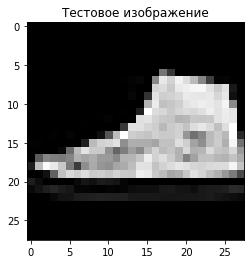

<Figure size 432x288 with 0 Axes>

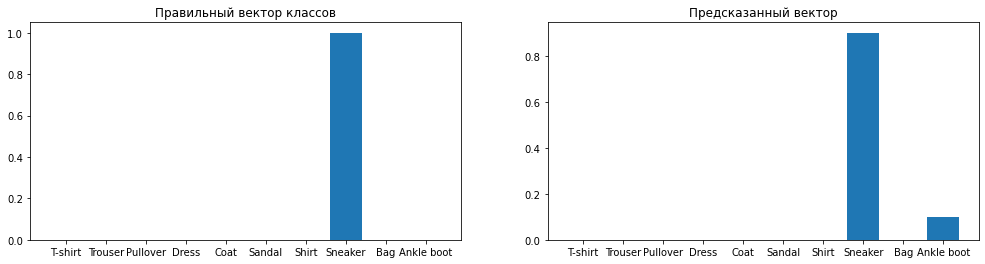

In [137]:
np.random.seed(123456)
test_ind = np.random.randint(test_images.shape[0])
test_image = test_images[test_ind]
test_vector = test_vectors[test_ind]
predicted_test_vector = classification_model.predict(test_image[np.newaxis]).reshape((10,))

plt.imshow(test_image, cmap='gray')
plt.title('Тестовое изображение')
plt.figure()

fig, ax = plt.subplots(1, 2, figsize=(17, 4))
ax[0].bar(range(10), test_vector, tick_label=classes)
ax[1].bar(range(10), predicted_test_vector, tick_label=classes)
for i, title in enumerate(['Правильный вектор классов', 'Предсказанный вектор']): ax[i].set_title(title)

Получим предсказания для первых 100 изображений:

In [138]:
%time
predicted_vectors = classification_model.predict(test_images[:100]).reshape((100, 10))

CPU times: total: 0 ns
Wall time: 0 ns
4/4 [==============================] - 0s 4ms/step


Посмотрим на каких изображениях сеть ошибается:

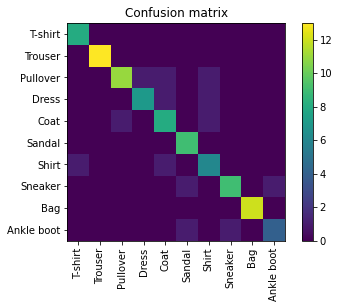

<Figure size 432x288 with 0 Axes>

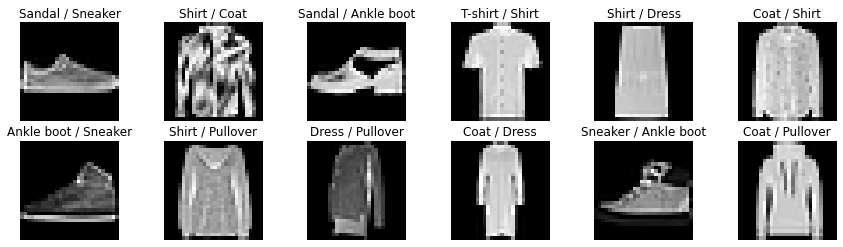

In [139]:
predicted_labels = np.argmax(predicted_vectors, axis=1)  # предсказанные индексы классов - где верояность наибольшая

pred = test_labels[:100] != predicted_labels
misclassified_images = test_images[:100][pred]
misclassified_correct = test_labels[:100][pred]
misclassified_predicted = predicted_labels[:100][pred]

cm = confusion_matrix(test_labels[:100], predicted_labels[:100])
plt.imshow(cm, interpolation='nearest')
plt.xticks(range(10), classes, rotation=90)
plt.yticks(range(10), classes)
plt.colorbar()
plt.title("Confusion matrix")
plt.figure()

fig, ax = plt.subplots(2, 6, figsize=(15, 4))
for i in range(2 * 6):
    ax.flatten()[i].imshow(misclassified_images[i], cmap='gray')
    ax.flatten()[i].axis('off')
    ax.flatten()[i].set_title(f"{classes[misclassified_predicted[i]]} / {classes[misclassified_correct[i]]}")

---

### Gradient Boosting для классификации изображений



Будем рассматривать ту же задачу, что и в прошлом задании.

_Примечание:_ здесь используем модель-результат второго задания - `classification_model` (модель-классификатор). Если ноутбук перезагружался, можно выполнить ячейку с кодом ниже, чтобы загрузить датасет и обученную в задании модель в память.

_Ещё примечание:_ второе задание, выполненное до этого шага, могло потребовать много ресурсов компьютера (особенно, если был использован keras tuner). Так как модель, полученная в прошлом задании, была сохранена, может быть удобно перезагрузить ноутбук, чтобы освободить занятые ресурсы, для выполнения следующих заданий.

In [140]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Переводим цвета из диапазона [0, 255] к диапазону [0, 1]
train_images = train_images / 255.0
test_images  = test_images / 255.0
# Переводим числовые метки в категориальные - вместо номера класса от 0 до 9 будем использовать векторы
# из 10 элементов, где все нули, кроме единицы на i-ой позиции для i-го класса.
# Такой подход позволяет избежать негативных эффектов при обучении, т.к. между классами нет строгого линейного порядка,
# как в случае с числами от 0 до 9.
train_vectors = to_categorical(train_labels)
test_vectors = to_categorical(test_labels)

second_task_saved_model = os.path.join("models", "task_2_weights.h5")
classification_model = load_model(second_task_saved_model)

Возьмём лишь часть модели `classification_model` (до полносвязных слоёв), чтобы получить векторы признаков - именно для этого при создании модели мы помечали слой `Flatten`.

In [141]:
# Из слоёв classification_model составим модель для извлечения вектора признаков
feature_extractor = Model(
    inputs=classification_model.inputs,
    outputs=classification_model.get_layer(name="flatten").output,  # Указываем слой, выходы после которого нас интересуют
)

Получим векторы признаков:

In [142]:
# Здесь predict означает прогон данных через feature_extractor: получаем промежуточные
# представления исходных объектов, чтобы на этих представлениях было проще обучить градиентный бустинг.
train_encoded = feature_extractor.predict(train_images, batch_size=32)
test_encoded = feature_extractor.predict(test_images, batch_size=32)
print(f'train_encoded.shape = {train_encoded.shape}')
print(f'test_encoded.shape = {test_encoded.shape}')

313/313 [==============================] - 1s 4ms/step
train_encoded.shape = (60000, 162)
test_encoded.shape = (10000, 162)


---

#### Задание 3.

Для векторов признаков, полученных из предыдущего задания, достроим классификатор на основе градиентного бустинга.

**Требуется:**

Изменить параметры `CatBoostClassifier` ниже, чтобы повысить качество (accuracy) на **тестовых данных** до **0.89**.

_Примечание:_ в случае, если ресурсов компьютера не хватает, и не помогает перезагрузка jupyter-ноутбука, можно попробовать выполнить это задание в [Google Colab](https://colab.research.google.com/). В таком случае не забудьте перенести в Colab сохранённую со второго задания модель, а после выполнения не забудьте добавить все необходимые данные в репозиторий.

In [143]:
dim_reduction = PCA(n_components=train_encoded.shape[-1]) # понизим размерность, используя информацию о классах
small_train_encoded = dim_reduction.fit_transform(train_encoded)
small_test_encoded = dim_reduction.transform(test_encoded)

In [146]:
image_gbm = CatBoostClassifier(
    loss_function='MultiClass',
    # эти параметры следует подобрать:
    depth=5,
    learning_rate=0.06,
    iterations=700,
)
image_gbm.fit(small_train_encoded, train_labels, verbose=0)

In [147]:
image_gbm_labels = image_gbm.predict(small_test_encoded)
image_gbm_score = accuracy_score(test_labels, image_gbm_labels)
print(f"Качество: {image_gbm_score}")
print(f"Порог по качеству " + ("пройден" if image_gbm_score >= 0.89 else "НЕ пройден"))

Качество: 0.8943
Порог по качеству пройден


Не забудьте сохранить ответ

In [148]:
third_task_saved_model = os.path.join("models", "task_3.cbm")
# Создаём папку, куда сохраним результаты, если папки ещё нет
Path("models").mkdir(parents=True, exist_ok=True)
image_gbm.save_model(third_task_saved_model)

add_to_answer(
    "task_3",
    {
        "model_path": third_task_saved_model,
    },
)

---

## Аугментация

Часто доступные на этапе обучения размеченные данные оказываются смещёнными, не целиком покрывающими допустимое для данной задачи распределение входных данных.
Также, при использовании нейронных сетей с большим числом параметров, на этапе обучения необходимо большое число различных данных, чтобы модель не деградировала до "табличной функции", запоминая все входные данные.

Для борьбы с обеими проблемами хорошо подходит подход искусственного расширения обучающего набора данных – аугментация. Идея заключается в применении случайных трансформаций к каждому отдельному изображению, при сохранении меток классов. Таким образом можно получить датасет произвольного размера и добиться от нейронной сети определённых свойств (разумеется, для фиксированного, ограниченного распределения входных данных), например: инвариантности к повороту объекта – за счёт обучения на всевозможных поворотах входных изображений.

Важно, что выбор набора трансформаций и распределений из которых генерируются их параметры, специфичен для каждой задачи. Например, при классификации деревьев не разумно выполнять повороты на $\pi$, поскольку известно, что деревья всегда растут снизу вверх.

---

Будем загружать датасет из GoogleDisk, воспользуемся библиотекой `googledrivedownloader`.

Скачаем файлы с данными:

In [ ]:
ids_to_file_names = {
    '1iFK4-fCqs8l5lWmYnUYlkv28GDb43FUv': 'fashion_images.npy',
    '15NUcK_Pg4iEUttK1XiG0SonJaEbaaVnI': 'fashion_labels.npy',
    '1AXtbCz3EE2xVuUrGgEco7a-lMh8Vqm0o': 'val_fashion_images.npy',
    '1fk1mZxBLRryWp4IoLHRr5IwiaKy4WL_Y': 'val_fashion_labels.npy',
    '1tWy1d9lkrCzkiSZBlfd1G6YV4sZ7pNt4': 'test_fashion_images.npy',
}

# Файлы будем загружать и сохранять в папку data
for _id in ids_to_file_names:
    ids_to_file_names[_id] = os.path.join("data", ids_to_file_names[_id])
    
# Создадим папку data, если её ещё нет
Path("data").mkdir(parents=True, exist_ok=True)
    
    
for file_id in ids_to_file_names:
    # Качаем файл только если он ещё не скачан
    if not os.path.isfile(ids_to_file_names[file_id]):
        gdd.download_file_from_google_drive(file_id=file_id,
                                            dest_path=os.path.join('.', ids_to_file_names[file_id]),
                                            unzip=True)

Загрузим данные – изображения 64x64 с цветным шумом и случайно аффинно трансформированными снимками одежды:

In [ ]:
def load_from_data(fname):
    return np.load(os.path.join("data", fname))

fashion_images = load_from_data("fashion_images.npy")
fashion_labels = load_from_data("fashion_labels.npy")

val_fashion_images = load_from_data("val_fashion_images.npy")
val_fashion_labels = load_from_data("val_fashion_labels.npy")

test_fashion_images = load_from_data("test_fashion_images.npy")

В качестве тренировочного и валидационного датасета даны изображения и метки (вектора вероятностей классов одежды), в качестве тестового – только изображения.

Ниже дана модель, гиперпараметры которой (количества каналов, размеры ядер, функции активации, архитектуру и т.п.) менять **нельзя**.

In [ ]:
def make_fashion_model():
    imodel = Sequential()
    imodel.add(Reshape((64, 64, 3), input_shape=(64, 64, 3)))
    imodel.add(Conv2D(4, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(8, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(MaxPooling2D())
    imodel.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1),
                         activation='relu', padding='same'))
    imodel.add(BatchNormalization())
    imodel.add(Flatten())

    iclf = Sequential()
    iclf.add(imodel)
    iclf.add(Dense(10, activation='softmax'))

    iclf.compile(optimizer='adam', 
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    
    return iclf

---

#### Задание 4 (дополнительное).

**Внимание!** Это задание повышенной сложности, за его решение даётся 2.5 балла, выполнять его необязательно.

Найти такие параметры аугментации (ниже), чтобы качество классификации (accuracy) на **тестовых** данных было **не ниже 0.6**.

*Настоятельно рекомендуется сначала внимательно изучить обучающую и тестовую выборки, а не подбирать параметры случайным образом.*

In [ ]:
train_fashion_images = fashion_images.copy()
# здесь можно сделать предварительную обработку всего обучающего датасета
train_fashion_labels = fashion_labels

In [ ]:
# здесь следует изменить параметры аугментации (параметры ImageDataGenerator):
aug_params = {  # Параметры задаём сначала в словаре, чтобы их потом сохранить
    "featurewise_center": False,
    "samplewise_center": False,
    "featurewise_std_normalization": False,
    "samplewise_std_normalization": False,
    "rotation_range": 0,
    "width_shift_range": 0.0,
    "height_shift_range": 0.0,
    "brightness_range": None,
    "shear_range": 0.0,
    "zoom_range": 0.0,
    "channel_shift_range": 0.0,
    "fill_mode": 'nearest',
    "cval": 0.0,
    "horizontal_flip": False,
    "vertical_flip": False,
    "rescale": None,
}

aug = ImageDataGenerator(**aug_params)

Из параметров обучения можно менять `batch_size` и `epochs`, но использовать можно не больше 200 эпох.

При желании можно разобраться в механизме callback'ов и передать в `fit` дополнительные параметры для автоматического сохранения весов модели к состоянию на "лучшей" итерации обучения (лучшей с точки зрения качества на валидационных данных), но это делать не обязательно.

In [ ]:
fit_params = {
    "batch_size": 128,
    "epochs": 200,
}

fashion_clf = make_fashion_model()

aug.fit(train_fashion_images)
gen = aug.flow(train_fashion_images, train_fashion_labels,
               batch_size=fit_params["batch_size"])

hist = fashion_clf.fit(
    gen,
    steps_per_epoch=len(train_fashion_images) // fit_params["batch_size"],
    validation_data=(val_fashion_images, val_fashion_labels),
    **fit_params,
)

In [ ]:
def plot_accuracy(history):
    acc = 'acc' if 'acc' in history else 'accuracy'
    val_acc = 'val_' + acc
    
    plt.plot(range(len(history[acc])), history[acc], color='b')
    plt.plot(range(len(history[val_acc])), history[val_acc], color='g')

    return hist.history[val_acc][-1]

plot_accuracy(hist.history)

Для проверки сохраняются веса сети:

In [ ]:
aug_saved_model = os.path.join("models", "task_4_weights.h5")
# Создаём папку, куда сохраним результаты, если папки ещё нет
Path("models").mkdir(parents=True, exist_ok=True)
fashion_clf.save(aug_saved_model)

add_to_answer(
    "task_4",
    {
        "model_path": aug_saved_model,
        "fit_params": fit_params,
        "aug_params": aug_params,
    },
)

Любые попытки получить более точную модель не с помощью аугментации запрещены.

---

## Выбор подходящей модели машинного обучения

Возьмём набор данных `wine`

In [ ]:
wine_x, wine_y = load_wine(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(wine_x, wine_y, test_size=0.2, random_state=123456)

---

#### Задание 5 (дополнительное).

Подберите модель машинного обучения для решения задачи _регрессии_ на данных из датасета `wine`.

Обучите выбранную модель, используя для обучения только данные `x_train`, `y_train`.

Данные `x_test`, `y_test` можно использовать в обучении _только в качестве валидационных данных_.

Метрика **MAE** (mean absolute error, средняя абсолютная ошибка) на **тестовых** данных (`x_test`, `y_test`) должна быть **меньше 0.1**.

_За выполнение этого задания можно получить 1 дополнительный балл, но выполнять это задание не обязательно_

In [ ]:
# Ваш код обучения модели
wine_regressor = ...

In [ ]:
print(f"MAE on test data = {mean_absolute_error(y_test, wine_regressor.predict(x_test))}")

---